In [1]:
import os
import re
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from test_utils import psnr, calculate_metrics_batch

# Paths
train_dir = "logs/vimeo_8/local/image_log/train"

# Updated regex patterns to handle variable parts
local_control_pattern = re.compile(r"gs-(\d+).*_local_control_\d+\.png")
reconstruction_pattern = re.compile(r"gs-(\d+).*_reconstruction\.png")

# Initialize lists for global steps, PSNR, and MS-SSIM
global_steps = []
psnr_values = []
mssim_values = []

# Preprocessing transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to 512x512
    transforms.ToTensor()
])

# Load all files
files = os.listdir(train_dir)

# Group files by global step
local_control_files = {}
reconstruction_files = {}

for file in files:
    local_match = local_control_pattern.match(file)
    recon_match = reconstruction_pattern.match(file)
    if local_match:
        global_step = int(local_match.group(1))
        local_control_files[global_step] = file
    elif recon_match:
        global_step = int(recon_match.group(1))
        reconstruction_files[global_step] = file

# Compute metrics for matching pairs
for global_step in sorted(local_control_files.keys()):
    if global_step in reconstruction_files:
        local_control_path = os.path.join(train_dir, local_control_files[global_step])
        reconstruction_path = os.path.join(train_dir, reconstruction_files[global_step])
        
        # Load images as PIL images
        original_image = Image.open(local_control_path).convert("RGB")
        reconstruction_image = Image.open(reconstruction_path).convert("RGB")
        
        # Calculate PSNR and MS-SSIM for the current pair
        metrics = calculate_metrics_batch([original_image], [reconstruction_image])
        
        # Append results
        global_steps.append(global_step)
        psnr_values.append(metrics['PSNR'])
        mssim_values.append(metrics['MS-SSIM'])

# Sort results by global steps
sorted_indices = sorted(range(len(global_steps)), key=lambda i: global_steps[i])
global_steps = [global_steps[i] for i in sorted_indices]
psnr_values = [psnr_values[i] for i in sorted_indices]
mssim_values = [mssim_values[i] for i in sorted_indices]

/data/maryam.sana/anaconda3/envs/unicontrol/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/data/maryam.sana/anaconda3/envs/unicontrol/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /data/maryam.sana/anaconda3/envs/unicontrol/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


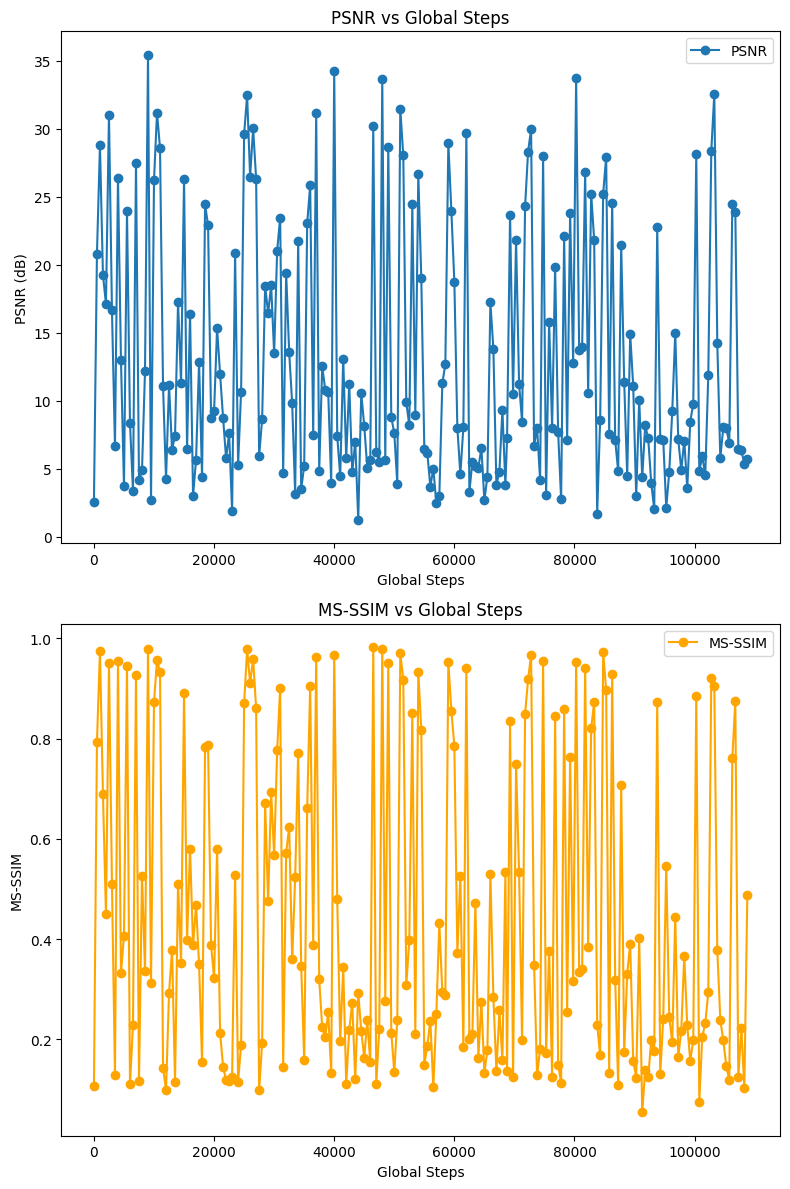

In [2]:
# Plot PSNR and MS-SSIM
plt.figure(figsize=(8, 12))  # Adjusted figure size for vertical alignment

# PSNR plot
plt.subplot(2, 1, 1)
plt.plot(global_steps, psnr_values, marker='o', label='PSNR')
plt.title("PSNR vs Global Steps")
plt.xlabel("Global Steps")
plt.ylabel("PSNR (dB)")
plt.legend()

# MS-SSIM plot
plt.subplot(2, 1, 2)
plt.plot(global_steps, mssim_values, marker='o', label='MS-SSIM', color='orange')
plt.title("MS-SSIM vs Global Steps")
plt.xlabel("Global Steps")
plt.ylabel("MS-SSIM")
plt.legend()

plt.tight_layout()
plt.show()


In [33]:
#lpips experiments 
import torch
import lpips
from PIL import Image
from torchvision import transforms

# Initialize the LPIPS model
loss_fn = lpips.LPIPS(net='vgg')  # Options: 'alex', 'vgg', 'squeeze'
loss_fn = loss_fn.cuda()  # Move to GPU if available

# Function to load and preprocess images
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to a fixed size (optional)
        transforms.ToTensor(),          # Convert PIL Image to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Normalize to [-1, 1]
                             std=[0.5, 0.5, 0.5]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image.unsqueeze(0)  # Add batch dimension

# Load images
img0 = load_image('/data/maryam.sana/vimeo_unicontrol/Uni-ControlNet/data/UVG/Beauty/im00002.png').cuda()  # Replace with your image paths
img1 = load_image('predictions/Beauty2/im2_pred.png').cuda()

# Compute LPIPS loss
with torch.no_grad():
    lpips_loss = loss_fn(img0, img1)
    print('LPIPS Loss:', lpips_loss.mean().item())



Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /data/maryam.sana/anaconda3/envs/unicontrol/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
LPIPS Loss: 0.3402749001979828


In [31]:
from ldm.models.diffusion.ddpm import LatentDiffusion
from ldm.util import log_txt_as_img, instantiate_from_config
from omegaconf import OmegaConf

config = OmegaConf.load('configs/uni_v15.yaml')

# model = instantiate_from_config(config['model'])
# latent_diffusion_model = LatentDiffusion(
#     first_stage_config= config.model.params['first_stage_config'],
#     cond_stage_config= config.model.params['cond_stage_config'],
#     unet_config = config.model.params['unet_config'],
#     num_timesteps_cond=1,
#     cond_stage_key="txt",
#     cond_stage_trainable=False,
#     concat_mode=True,
#     cond_stage_forward=None,
#     conditioning_key="crossattn",
#     scale_factor=0.18215,
#     scale_by_std=False,
#     force_null_conditioning=False,
#     linear_start=0.00085,
#     linear_end=0.0120,
#     timesteps=1000,
#     log_every_t=200,
#     image_size=64,
#     channels=4,
#     monitor="val/loss_simple_ema",
#     use_ema=False,
# )

In [6]:
import torch

# List of checkpoint files
ckpt_files = [
    "path/to/local.ckpt",
    "path/to/local-v1.ckpt",
    "path/to/local-v3.ckpt",
    "path/to/local-v4.ckpt"
]

def inspect_checkpoint(ckpt_file):
    print(f"Inspecting {ckpt_file}...")
    checkpoint = torch.load(ckpt_file, map_location=torch.device('cpu'))

    # Extract metadata
    epoch = checkpoint.get('epoch', 'Unknown')
    global_step = checkpoint.get('global_step', 'Unknown')
    hyperparameters = checkpoint.get('hyper_parameters', {})

    print(f"Epoch: {epoch}")
    print(f"Global Step: {global_step}")
    print("Hyperparameters:")
    for key, value in hyperparameters.items():
        print(f"  {key}: {value}")
    print("-" * 50)

# Inspect all checkpoint files
# for ckpt_file in ckpt_files:
inspect_checkpoint('checkpoints/vimeo_8/local-best-checkpoint-v5.ckpt')

Inspecting checkpoints/vimeo_8/local-best-checkpoint-v5.ckpt...


/tmp/ipykernel_3271720/3216847511.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_file, map_location=torch.device('cpu'))


Epoch: 1
Global Step: 100500
Hyperparameters:
--------------------------------------------------


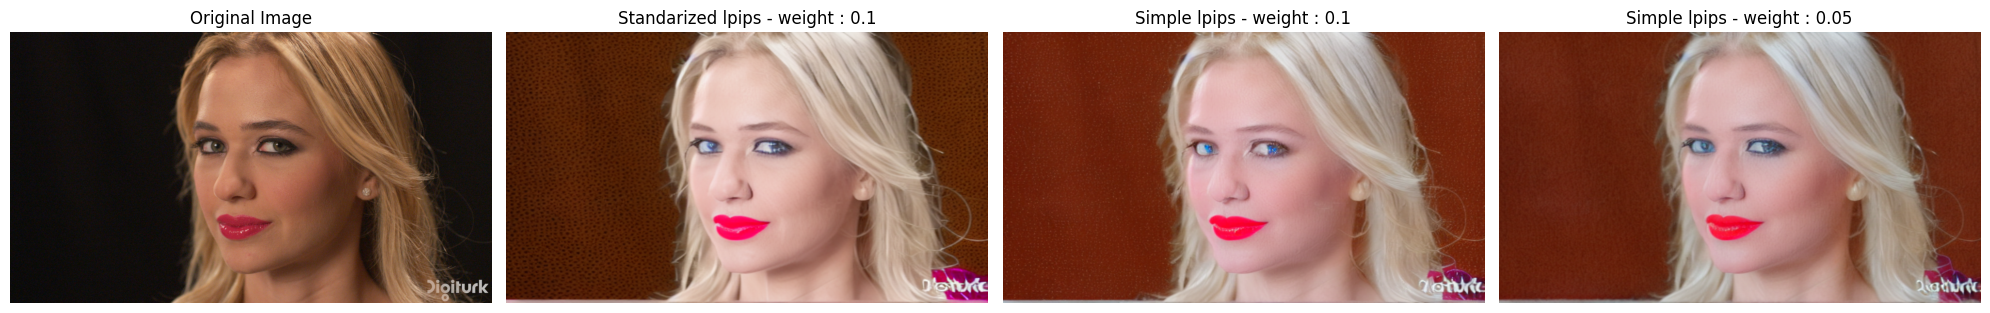

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

# Define paths to the images
image_paths = [
    '/data/maryam.sana/vimeo_unicontrol/Uni-ControlNet/data/UVG/Beauty/im00002.png',
    'predictions/lpips_s_01/im2_pred.png',
    'predictions/lpips_01/im2_pred.png',
    'predictions/lpips_005/im2_pred.png'
]

# Define captions for each image
captions = [
    "Original Image",
    "Standarized lpips - weight : 0.1",
    "Simple lpips - weight : 0.1",
    "Simple lpips - weight : 0.05",
]

# Load the images
images = [Image.open(path) for path in image_paths]

# Create the figure
fig, axes = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 4 columns

# Loop through the images and captions
for i, (img, caption) in enumerate(zip(images, captions)):
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off the axis
    axes[i].set_title(caption, fontsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
